# **KNN**

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate  # Opsional untuk tampilan tabel lebih bagus

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour  # Jam (0-23)
df["weekday"] = df["datetime"].dt.weekday  # Hari dalam seminggu (0=Senin, ..., 6=Minggu)
df["day"] = df["datetime"].dt.day  # Hari dalam bulan (1-31)
df["month"] = df["datetime"].dt.month  # Bulan (1-12)
df["year"] = df["datetime"].dt.year  # Tahun

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", "AU23", "AU01", "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"  # Partisipan ID untuk validasi

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Simpan hasil evaluasi untuk setiap partisipan
eval_results = []

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    # Pisahkan data uji (satu partisipan)
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]

    # Pisahkan data latih (selain partisipan yang diuji)
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    # Cek distribusi label dalam data uji
    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue  # Lewati partisipan ini agar evaluasi lebih valid

    # Inisialisasi dan latih model KNN
    model = KNeighborsClassifier(n_neighbors=5)  # Gunakan k=5 sebagai default
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung metrik evaluasi dengan penanganan error
    eval_metrics = {
        "PID": pid_test,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan  # Gunakan NaN jika hanya ada satu kelas
    }
    eval_results.append(eval_metrics)

# Konversi hasil evaluasi ke DataFrame
eval_df = pd.DataFrame(eval_results)

# Hitung rata-rata metrik evaluasi
overall_metrics = eval_df.mean(numeric_only=True)
overall_metrics["PID"] = "Average"  # Tambahkan baris rata-rata

# Tambahkan hasil rata-rata ke tabel evaluasi
eval_df = pd.concat([eval_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Tampilkan tabel evaluasi
print("\nHasil Evaluasi Keseluruhan:")
print(tabulate(eval_df, headers="keys", tablefmt="grid", floatfmt=".4f"))  # Tabel lebih rapi

# Simpan hasil evaluasi ke file CSV
# eval_df.to_csv("hasil_evaluasi.csv", index=False)
# print("\n✅ Hasil evaluasi telah disimpan dalam 'hasil_evaluasi.csv'.")



⚠️ Peringatan: Data uji untuk PID P17 hanya memiliki satu kelas (0).

⚠️ Peringatan: Data uji untuk PID P25 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P27 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P28 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P34 hanya memiliki satu kelas (1).

Hasil Evaluasi Keseluruhan:
+----+---------+------------+-------------+----------+------------+--------+
|    | PID     |   Accuracy |   Precision |   Recall |   F1 Score |    AUC |
+====+=========+============+=============+==========+============+========+
|  0 | P08     |     0.4512 |      0.3564 |   0.6224 |     0.4532 | 0.4861 |
+----+---------+------------+-------------+----------+------------+--------+
|  1 | P10     |     0.6310 |      0.6511 |   0.6463 |     0.6487 | 0.6593 |
+----+---------+------------+-------------+----------+------------+--------+
|  2 | P12     |     0.6570 |      0.4583 |   0.7669 |     0.5737 | 0.7290 |
+----

precission recal

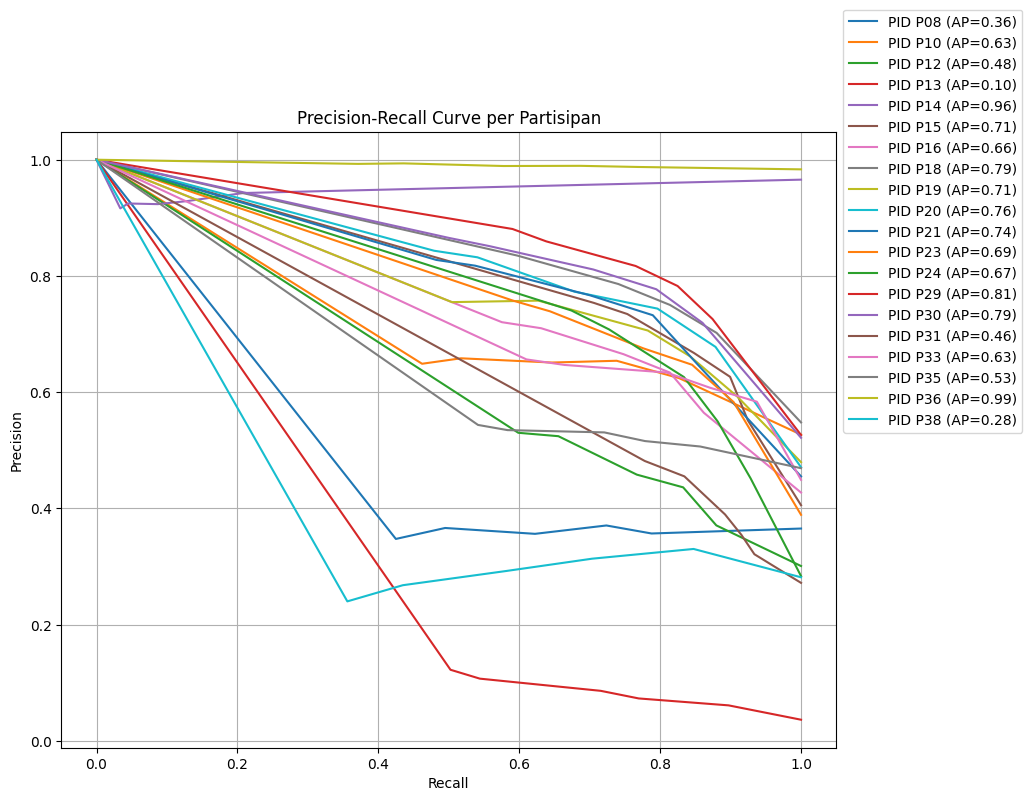

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Simpan probabilitas prediksi dan label sebenarnya untuk setiap partisipan
y_probs = []
y_trues = []
pids = []

# Ulangi proses LOPO Cross-Validation untuk menyimpan y_prob dan y_test
for pid_test in groups:
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    # Cek distribusi label dalam data uji
    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        continue  # Lewati partisipan ini agar evaluasi lebih valid

    # Inisialisasi dan latih model KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)

    # Prediksi probabilitas
    y_prob = model.predict_proba(X_test)[:, 1]

    # Simpan hasil untuk plotting
    y_probs.append(y_prob)
    y_trues.append(y_test)
    pids.append(pid_test)

# Plot Precision-Recall Curve untuk setiap partisipan
plt.figure(figsize=(10, 8))
for i in range(len(pids)):
    precision, recall, _ = precision_recall_curve(y_trues[i], y_probs[i])
    ap_score = average_precision_score(y_trues[i], y_probs[i])
    plt.plot(recall, precision, label=f'PID {pids[i]} (AP={ap_score:.2f})')

# Tambahkan label dan legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Partisipan')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


⚠️ Peringatan: Data uji untuk PID P17 hanya memiliki satu kelas (0).

⚠️ Peringatan: Data uji untuk PID P25 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P27 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P28 hanya memiliki satu kelas (1).

⚠️ Peringatan: Data uji untuk PID P34 hanya memiliki satu kelas (1).


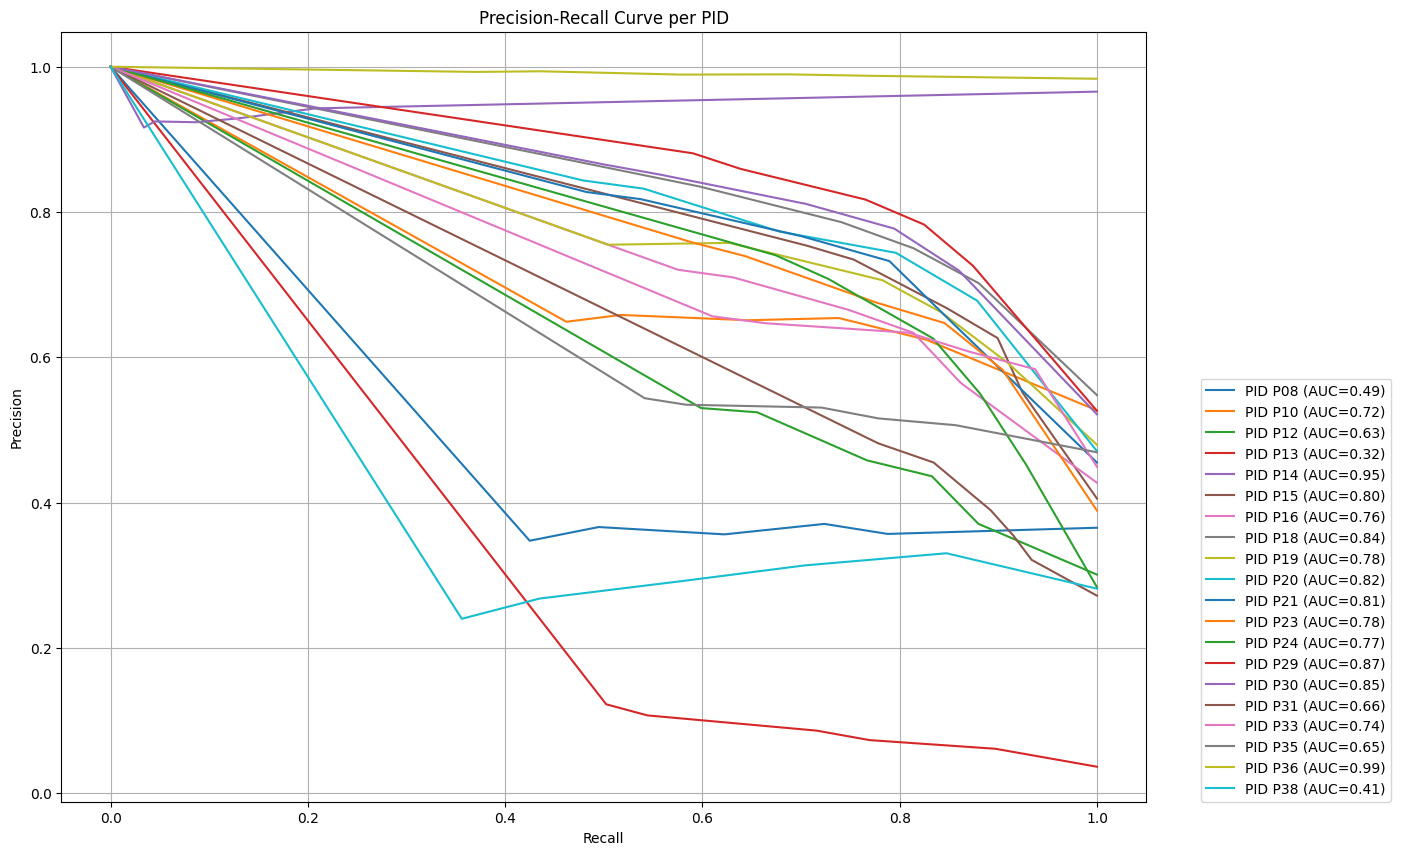

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", "AU23", "AU01", 
    "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Siapkan plot
plt.figure(figsize=(14, 10))

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    # Pisahkan data uji dan latih
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    # Cek distribusi label dalam data uji
    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue

    # Inisialisasi dan latih model KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)

    # Prediksi probabilitas untuk perhitungan Precision-Recall Curve
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall Curve untuk setiap PID
    plt.plot(recall, precision, label=f"PID {pid_test} (AUC={pr_auc:.2f})")

# Konfigurasi plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per PID')
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0)
plt.grid(True)
plt.show()


auc

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Inisialisasi figure
plt.figure(figsize=(10, 8))

# Loop untuk setiap partisipan
for pid_test in groups:
    # Pisahkan data uji dan latih
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    # Cek distribusi label dalam data uji
    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        continue  # Lewati partisipan ini jika hanya ada satu kelas

    # Inisialisasi dan latih model KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)

    # Prediksi probabilitas
    y_prob = model.predict_proba(X_test)[:, 1]

    # Hitung ROC curve dan AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve untuk partisipan ini
    plt.plot(fpr, tpr, label=f'PID {pid_test} (AUC = {roc_auc:.2f})')

# Plot garis diagonal sebagai baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Label dan judul grafik
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Participant')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Simpan hasil evaluasi ke file CSV
eval_df.to_csv("hasil_evaluasi.csv", index=False)
print("\n✅ Hasil evaluasi telah disimpan dalam 'hasil_evaluasi.csv'.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan data untuk visualisasi sudah siap
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
eval_df_visual = eval_df[eval_df["PID"] != "Average"]  # Kecualikan rata-rata

# 1. Bar Plot untuk setiap metrik per partisipan
plt.figure(figsize=(16, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x="PID", y=metric, data=eval_df_visual, palette="viridis")
    plt.title(f"{metric} per PID")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Skala 0-1 untuk semua metrik
    plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# 2. Box Plot untuk distribusi metrik
plt.figure(figsize=(14, 8))
sns.boxplot(data=eval_df_visual[metrics], palette="muted")
plt.title("Distribusi Metrik Evaluasi")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# **Xgboost**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate  # Untuk tampilan tabel lebih rapi

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour  
df["weekday"] = df["datetime"].dt.weekday  
df["day"] = df["datetime"].dt.day  
df["month"] = df["datetime"].dt.month  
df["year"] = df["datetime"].dt.year  

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", 
    "AU23", "AU01", "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"  

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Simpan hasil evaluasi untuk setiap partisipan
eval_results = []
feature_importance_list = {feature: [] for feature in feature_columns}

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue  

    # Inisialisasi dan latih model XGBoost
    model = xgb.XGBClassifier(
        objective="binary:logistic", 
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung metrik evaluasi
    eval_metrics = {
        "PID": pid_test,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
    }
    eval_results.append(eval_metrics)

    # Simpan feature importance dari model
    feature_importances = model.feature_importances_
    for feature, importance in zip(feature_columns, feature_importances):
        feature_importance_list[feature].append(importance)

# Konversi hasil evaluasi ke DataFrame
eval_df = pd.DataFrame(eval_results)

# Hitung rata-rata metrik evaluasi
overall_metrics = eval_df.mean(numeric_only=True)
overall_metrics["PID"] = "Average"  

# Tambahkan hasil rata-rata ke tabel evaluasi
eval_df = pd.concat([eval_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Konversi feature importance ke DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": [np.mean(feature_importance_list[feature]) for feature in feature_columns]
}).sort_values(by="Importance", ascending=False)

# Tampilkan tabel evaluasi
print("\n📊 Hasil Evaluasi Keseluruhan:")
print(tabulate(eval_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Tampilkan Feature Importance
print("\n🔥 Feature Importance dari XGBoost:")
print(tabulate(feature_importance_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

print("\n✅ Hasil evaluasi telah ditampilkan.")

In [ ]:
eval_df.to_csv("hasil_evaluasi_xgboost.csv", index=False)
print("\n✅ Hasil evaluasi telah disimpan dalam 'hasil_evaluasi.csv'.")

# **Decission Three**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate  # Untuk tampilan tabel lebih rapi

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour  
df["weekday"] = df["datetime"].dt.weekday  
df["day"] = df["datetime"].dt.day  
df["month"] = df["datetime"].dt.month  
df["year"] = df["datetime"].dt.year  

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", 
    "AU23", "AU01", "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"  

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Simpan hasil evaluasi untuk setiap partisipan
eval_results = []
feature_importance_list = {feature: [] for feature in feature_columns}

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue  

    # Inisialisasi dan latih model Decision Tree
    model = DecisionTreeClassifier(
        criterion="gini",  # Bisa diganti dengan "entropy"
        max_depth=5,       # Batasi kedalaman agar tidak overfitting
        random_state=42
    )
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung metrik evaluasi
    eval_metrics = {
        "PID": pid_test,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
    }
    eval_results.append(eval_metrics)

    # Simpan feature importance dari model
    feature_importances = model.feature_importances_
    for feature, importance in zip(feature_columns, feature_importances):
        feature_importance_list[feature].append(importance)

# Konversi hasil evaluasi ke DataFrame
eval_df = pd.DataFrame(eval_results)

# Hitung rata-rata metrik evaluasi
overall_metrics = eval_df.mean(numeric_only=True)
overall_metrics["PID"] = "Average"  

# Tambahkan hasil rata-rata ke tabel evaluasi
eval_df = pd.concat([eval_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Konversi feature importance ke DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": [np.mean(feature_importance_list[feature]) for feature in feature_columns]
}).sort_values(by="Importance", ascending=False)

# Tampilkan tabel evaluasi
print("\n📊 Hasil Evaluasi Keseluruhan:")
print(tabulate(eval_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Tampilkan Feature Importance
print("\n🌳 Feature Importance dari Decision Tree:")
print(tabulate(feature_importance_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

print("\n✅ Hasil evaluasi telah ditampilkan.")


# **Naive Bayes**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate  # Untuk tampilan tabel lebih rapi

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour  
df["weekday"] = df["datetime"].dt.weekday  
df["day"] = df["datetime"].dt.day  
df["month"] = df["datetime"].dt.month  
df["year"] = df["datetime"].dt.year  

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", 
    "AU23", "AU01", "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"  

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Simpan hasil evaluasi untuk setiap partisipan
eval_results = []

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue  

    # Inisialisasi dan latih model Naïve Bayes
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung metrik evaluasi
    eval_metrics = {
        "PID": pid_test,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
    }
    eval_results.append(eval_metrics)

# Konversi hasil evaluasi ke DataFrame
eval_df = pd.DataFrame(eval_results)

# Hitung rata-rata metrik evaluasi
overall_metrics = eval_df.mean(numeric_only=True)
overall_metrics["PID"] = "Average"  

# Tambahkan hasil rata-rata ke tabel evaluasi
eval_df = pd.concat([eval_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Tampilkan tabel evaluasi
print("\n📊 Hasil Evaluasi Keseluruhan:")
print(tabulate(eval_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

print("\n✅ Hasil evaluasi telah ditampilkan.")


In [ ]:
eval_df.to_csv("hasil_evaluasi_Naive Bayes.csv", index=False)
print("\n✅ Hasil evaluasi telah disimpan dalam 'hasil_evaluasi.csv'.")

# **Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate  # Untuk tampilan tabel lebih rapi

# Load dataset
output = "/kaggle/input/data-baru/Normalisasi_data.csv"
df = pd.read_csv(output)

# Konversi datetime menjadi format waktu
df["datetime"] = pd.to_datetime(df["datetime"])

# Ekstrak bagian waktu
df["hour"] = df["datetime"].dt.hour  
df["weekday"] = df["datetime"].dt.weekday  
df["day"] = df["datetime"].dt.day  
df["month"] = df["datetime"].dt.month  
df["year"] = df["datetime"].dt.year  

# Pilih fitur yang digunakan untuk training
feature_columns = [
    "AU24", "hour", "weekday", "day", "month", "Eye_Open_Avg", "Facial_Structure", 
    "AU23", "AU01", "AU07", "AU02", "AU_Smile", "AU10", "AU14"
]

target_column = "depression_episode"
group_column = "pid"  

# Pisahkan fitur (X), target (y), dan kelompok (pid)
X = df[feature_columns]
y = df[target_column]
groups = df[group_column].unique()

# Simpan hasil evaluasi untuk setiap partisipan
eval_results = []
feature_importance_list = {feature: [] for feature in feature_columns}

# LOPO Cross-Validation (Leave-One-Participant-Out)
for pid_test in groups:
    X_test = X[df[group_column] == pid_test]
    y_test = y[df[group_column] == pid_test]
    X_train = X[df[group_column] != pid_test]
    y_train = y[df[group_column] != pid_test]

    label_counts = y_test.value_counts()
    if len(label_counts) < 2:
        print(f"\n⚠️ Peringatan: Data uji untuk PID {pid_test} hanya memiliki satu kelas ({label_counts.index[0]}).")
        continue  

    # Inisialisasi dan latih model Random Forest
    model = RandomForestClassifier(
        n_estimators=100,  # Jumlah pohon dalam hutan
        max_depth=5,       # Batasi kedalaman agar tidak overfitting
        random_state=42
    )
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) > 1 else np.zeros_like(y_test)

    # Hitung metrik evaluasi
    eval_metrics = {
        "PID": pid_test,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
    }
    eval_results.append(eval_metrics)

    # Simpan feature importance dari model
    feature_importances = model.feature_importances_
    for feature, importance in zip(feature_columns, feature_importances):
        feature_importance_list[feature].append(importance)

# Konversi hasil evaluasi ke DataFrame
eval_df = pd.DataFrame(eval_results)

# Hitung rata-rata metrik evaluasi
overall_metrics = eval_df.mean(numeric_only=True)
overall_metrics["PID"] = "Average"  

# Tambahkan hasil rata-rata ke tabel evaluasi
eval_df = pd.concat([eval_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Konversi feature importance ke DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": [np.mean(feature_importance_list[feature]) for feature in feature_columns]
}).sort_values(by="Importance", ascending=False)

# Tampilkan tabel evaluasi
print("\n📊 Hasil Evaluasi Keseluruhan:")
print(tabulate(eval_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Tampilkan Feature Importance
print("\n🌲 Feature Importance dari Random Forest:")
print(tabulate(feature_importance_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

print("\n✅ Hasil evaluasi telah ditampilkan.")

In [ ]:
eval_df.to_csv("hasil_evaluasi_Random Forest.csv", index=False)
print("\n✅ Hasil evaluasi telah disimpan dalam 'hasil_evaluasi.csv'.")